# Algoritmo PCA

El algoritmo PCA (Análisis de Componentes Principales) permite encontrar una representación de baja dimensionalidad $\mathbf{y_i}$ que explica la varianza de los datos originales $\mathbf{x_i}$. 

\begin{align*}
\mathbf{y_i}=U^T (\mathbf{x_i}-\mu)\\
\tilde{\mathbf{x_i}}=U \mathbf{y_i} +\mu
\end{align*}

In [20]:
using LinearAlgebra; 
using MultivariateStats;
using Statistics;

X=[ 7  4  3;
    4  1  8; 
    6  3  5;
    8  6  1;
    8  5  7;
    7  2  9;
    5  3  3;
    9  5  8;
    7  4  5;
    8  2  2];
μ=mean!([1. 1. 1.],X)
X_m=(X.-μ)
M = fit(PCA, transpose(X_m),maxoutdim=3)
Yte = transform(M, transpose(X_m))
X_r=transpose(reconstruct(M, Yte)).+μ
E=norm(X-X_r)

3.2023728339893768e-15

In [5]:
M

PCA(indim = 3, outdim = 2, principalratio = 0.9409505391500154)

Pattern matrix (unstandardized loadings):
──────────────────────
         PC1       PC2
──────────────────────
1  -0.395715  1.34028
2  -0.720434  1.26714
3   2.75651   0.523582
──────────────────────

Importance of components:
─────────────────────────────────────────────
                                PC1       PC2
─────────────────────────────────────────────
SS Loadings (Eigenvalues)  8.27394   3.67613
Variance explained         0.651492  0.289459
Cumulative variance        0.651492  0.940951
Proportion explained       0.692376  0.307624
Cumulative proportion      0.692376  1.0
─────────────────────────────────────────────

In [6]:
typeof(X_m)

Matrix{Float64} (alias for Array{Float64, 2})

In [7]:
values,vectors=eigen(cov(X_m));

In [9]:
U=[vectors[:,3] vectors[:,2]]
V=sort(values[2:3],rev=true)
U_s=sqrt.(V)'.*U

3×2 Matrix{Float64}:
 -0.395715  -1.34028
 -0.720434  -1.26714
  2.75651   -0.523582

In [10]:
U

3×2 Matrix{Float64}:
 -0.137571  -0.699037
 -0.25046   -0.660889
  0.958303  -0.27308

In [11]:
M.prinvars

2-element Vector{Float64}:
 8.273942580407862
 3.6761292667973366

In [12]:
V

2-element Vector{Float64}:
 8.273942580407862
 3.6761292667973366

In [13]:
M.proj

3×2 Matrix{Float64}:
 -0.137571  -0.699037
 -0.25046   -0.660889
  0.958303  -0.27308

In [14]:
imp=V./sum(V)
print("Proportion explained : $imp")

Proportion explained : [0.6923759694669046, 0.3076240305330955]

In [15]:
Y_t=transpose(U)*transpose(X_m)
X_r2=transpose(U*Y_t).+μ

10×3 Matrix{Float64}:
 7.07496  3.92443   2.99101
 4.35819  0.638889  7.95704
 6.18905  2.8094    4.97733
 8.4573   5.53896   0.945154
 8.31521  4.68222   6.9622
 6.43642  2.56818   9.06759
 5.56336  2.43204   2.93243
 8.88185  5.11912   8.01417
 7.19307  3.80535   4.97684
 6.53059  3.48141   2.17623

In [16]:
transpose(U)

2×3 transpose(::Matrix{Float64}) with eltype Float64:
 -0.137571  -0.25046    0.958303
 -0.699037  -0.660889  -0.27308

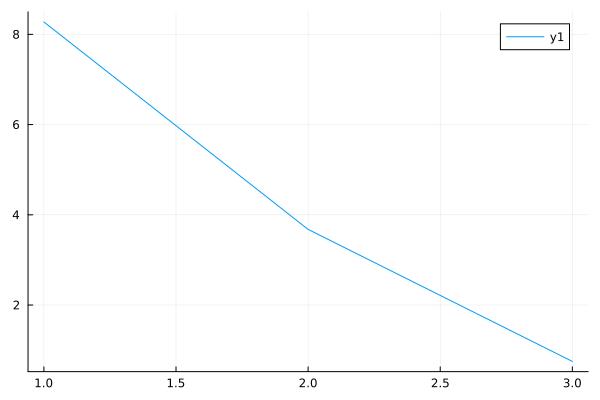

In [17]:
using Plots;

plot(sort(values,rev=true))

In [18]:
norm(X-X_r)

2.5979517653630966

# EigenFaces

En el caso del reconocimiento facial, el algoritmo Eigenfaces utiliza esta representación de baja dimensionalidad para comparar caras nuevas (no utilizadas para ajustar los valores y vectores propios). Sin embargo, una de los problemas al utlizar esta técnica es determinar la dimensionalidad \emph{intrinsica} de los datos. Esto quiere decir que el número de componentes principales es desconocido y debe determinarse mediante un compromiso entre el error de reconstrucción $E=\sum_i^n (\mathbf{x_i}-\tilde{\mathbf{x_i}})^2$ y la capacidad de comprimir y explicar los datos.

https://bio322.epfl.ch/notebooks/pca.html

In [2]:
using Images,Colors
using ImageTransformations

path="eigenvalue_pics/"
dim=64

function images_to_mat(pathlist,dim,data_type)
    mat=zeros(data_type,length(pathlist),dim*dim)
    for (index,images) in enumerate(pathlist)
        img=load(images)
        img_g=Gray.(img)
        img_g=imresize(img_g,dim,dim)
        img_g=data_type.(img_g)
        img_g=reshape(img_g,(1,dim*dim))
        mat[index,:]=img_g
    end 
    return mat
end



images_to_mat (generic function with 1 method)

In [207]:
pathlist=[]
names=[]
for d in readdir(path)
    for f in readdir(path*d)
        file_path=path*d*"/"*f
        push!(pathlist,file_path)
        push!(names,d)
    end 
end 

In [208]:
using LinearAlgebra; 
using MultivariateStats;
using Statistics;

my_type=Float64
mat=images_to_mat(pathlist,dim,my_type)
mean_face=mean!(transpose(ones(dim*dim)),mat)
centered_mat=mat.-my_type.(mean_face);

In [212]:
values,vectors=eigen(cov(centered_mat));

In [213]:
typeof(vectors)

Matrix{Float64} (alias for Array{Float64, 2})

In [214]:
sorted_values=sort(values,rev=true);

In [215]:
length(sorted_values)

4096

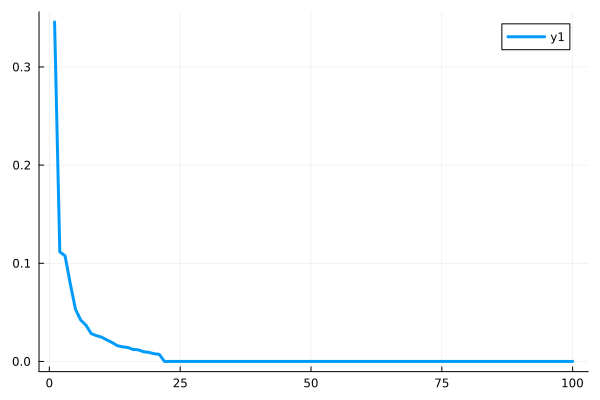

In [216]:
using Plots;

sorted_values=sorted_values./sum(sorted_values)
plot(sorted_values[1:100],lw=3)

In [217]:
size(vectors)

(4096, 4096)

In [218]:
num_components=25

25

In [219]:
eigenfaces=vectors[:,dim*dim:-1:(dim*dim-num_components+1)];

In [220]:
size(eigenfaces)

(4096, 25)

In [221]:
P=transpose(eigenfaces)*transpose(centered_mat);

In [223]:
size(mat)

(22, 4096)

In [222]:
size(P)

(25, 22)

# Error de predicción

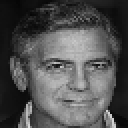

In [226]:
img=load("test.jpg")
img_g=Gray.(img)
img_g=imresize(img_g,dim,dim)

In [227]:
x_i=reshape(my_type.(img_g),(1,dim*dim))-mean_face
P_i=transpose(eigenfaces)*transpose(x_i);

In [229]:
size(eigenfaces)

(4096, 25)

In [230]:
eigenfaces

4096×25 Matrix{Float64}:
 0.0306666  -0.00267223  -0.000264831  …  -0.0300175     0.061774
 0.0301214  -0.00163106   0.000259406      0.0017619    -0.00619827
 0.0294534  -0.00105044   0.000612201     -0.0131644    -0.000600148
 0.0313491  -0.00277249  -0.00164452       0.022573     -0.0215841
 0.0311673  -0.00313947  -0.00177164      -0.0140514     0.0365378
 0.0304485  -0.00278952   5.81971e-6   …   0.0102105     0.00570964
 0.0306572  -0.00194028  -0.000491431     -0.0328622     0.00705555
 0.030426   -0.00181294  -0.00125876       0.0139484    -0.0147312
 0.0303422  -0.00161067  -0.00156127      -0.0223678     0.0343283
 0.0305603  -0.00185791  -0.0017049       -0.0184884     0.0287407
 ⋮                                     ⋱                
 0.0238278   0.00670279  -0.0221584        0.0436422     0.0767788
 0.0182808   0.0224548   -0.0127371       -0.000916084  -0.00377917
 0.0188464   0.0224763   -0.010077         0.0138139    -0.129266
 0.0189725   0.0212303   -0.0116033    …  -

In [231]:
dist=[]
for i in 1:22
    push!(dist,norm(P[:,i]-P_i))
end
pred=names[argmin(dist)]
print("La persona es : $pred")

La persona es : clooney

# Cuantización

In [132]:
function quantization(x, s, z, alpha_q, beta_q)
    x_q=((1 / s) * x).+z
    x_q = round.(x_q)
    x_q = clamp.(x_q, alpha_q, beta_q)
    return x_q
end

function quantization_int8(x, s, z)
    x_q = quantization(x, s, z, alpha_q=-128, beta_q=127)
    x_q = Int8.(x_q)
    return x_q
end

function dequantization(x_q, s, z)
    # x_q - z might go outside the quantization range.
    x_q = Float32.(x_q)
    x = s * (x_q .- z)
    x = Float32.(x)
    return x
end

function generate_quantization_constants(alpha, beta, alpha_q, beta_q)
    # Affine quantization mapping
    s = (beta - alpha) / (beta_q - alpha_q)
    z = ((beta * alpha_q - alpha * beta_q) / (beta - alpha))
    return s, z
end

generate_quantization_constants (generic function with 1 method)

In [235]:
b=8
r=randn(10);

alpha=minimum(r)
beta=maximum(r)
alpha_q = -2^(b - 1)
beta_q = 2^(b - 1) - 1

s,z=generate_quantization_constants(alpha,beta,alpha_q,beta_q)
q_r=quantization(r,s,z,alpha_q,beta_q);

In [240]:
q_r

10-element Vector{Float64}:
  127.0
  -22.0
   53.0
   11.0
  -54.0
   66.0
    0.0
   31.0
 -128.0
   -2.0

In [244]:
for (i,j,k) in zip( dequantization(q_r,s,z),r,Int8.(round.(r)))
    println("valor original : $j, valor cuantizado $i, valor truncado : $k")
end

valor original : 1.7957092176118001, valor cuantizado 1.7957093, valor truncado : 2
valor original : -0.23057653279197854, valor cuantizado -0.22957319, valor truncado : 0
valor original : 0.7861176059425875, valor cuantizado 0.78986424, valor truncado : 1
valor original : 0.21790242543495977, valor cuantizado 0.21897928, valor truncado : 0
valor original : -0.6617305140365336, valor cuantizado -0.6645332, valor truncado : -1
valor original : 0.9640620228497189, valor cuantizado 0.96656674, valor truncado : 1
valor original : 0.07382520772007613, valor cuantizado 0.06946179, valor truncado : 0
valor original : 0.4920996041805859, valor cuantizado 0.4908293, valor truncado : 0
valor original : -1.6703781302325562, valor cuantizado -1.6703781, valor truncado : -2
valor original : 0.0357393344977553, valor cuantizado 0.042276796, valor truncado : 0


In [245]:
error=norm(r-Int8.(round.(r)))

0.8132559553215049

In [246]:
error=norm(r-dequantization(q_r,s,z))

0.009681102678974823

In [247]:
r=eigenfaces[:,1]
alpha=minimum(r)
beta=maximum(r)
alpha_q = -2^(b - 1)
beta_q = 2^(b - 1) - 1

s,z=generate_quantization_constants(alpha,beta,alpha_q,beta_q)
q_r=quantization(r,s,z,alpha_q,beta_q);
q_r=Int8.(q_r)

4096-element Vector{Int8}:
 104
 101
  97
 108
 107
 102
 104
 102
 102
 103
   ⋮
  64
  32
  35
  36
  16
  14
  15
  12
  -4

In [248]:
q_r

4096-element Vector{Int8}:
 104
 101
  97
 108
 107
 102
 104
 102
 102
 103
   ⋮
  64
  32
  35
  36
  16
  14
  15
  12
  -4

In [249]:
error=norm(r-dequantization(q_r,s,z))

0.0032060688258161605

# Error de Reconstrucción

In [250]:
R=transpose(eigenfaces*P).+mean_face

22×4096 Matrix{Float64}:
 0.803922  0.807843  0.811765  0.815686  …  0.0666667  0.109804   0.113725
 0.137255  0.141176  0.152941  0.168627     0.0705882  0.0784314  0.054902
 0.6       0.576471  0.521569  0.494118     0.592157   0.498039   0.388235
 0.294118  0.309804  0.32549   0.345098     0.0784314  0.054902   0.0196078
 0.27451   0.290196  0.294118  0.294118     0.133333   0.152941   0.0862745
 0.4       0.392157  0.384314  0.376471  …  0.529412   0.52549    0.533333
 0.294118  0.294118  0.298039  0.298039     0.411765   0.435294   0.458824
 0.372549  0.380392  0.384314  0.384314     0.407843   0.392157   0.0901961
 0.788235  0.792157  0.792157  0.792157     0.803922   0.819608   0.0235294
 0.262745  0.262745  0.266667  0.258824     0.223529   0.266667   0.478431
 ⋮                                       ⋱                        ⋮
 0.643137  0.658824  0.662745  0.67451      0.807843   0.803922   0.8
 0.541176  0.545098  0.545098  0.552941     0.862745   0.866667   0.866667
 0.99215

In [251]:
R_i=transpose(eigenfaces*P_i).+mean_face

1×4096 Matrix{Float64}:
 0.0798434  0.0893099  0.106362  0.0641016  …  0.0989182  0.186536  0.218724

In [252]:
norm(mat-R)

2.3023800226312616e-13

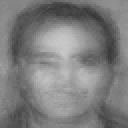

In [253]:
Gray.((reshape(mean_face,(dim,dim))))

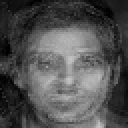

In [272]:
Gray.((reshape(R_i,(dim,dim))))